# Определение перспективного тарифа для телеком компании

**Описание и задачи проекта**

Необходимо проанализировать два тарифных плана федерального сотового оператора - "Смарт" и "Ультра" в целях корректировки рекламного бюджета. Цель - понять какой тариф приносит больше денег.

Исходные данные выборка в 500 клиентов, с данными клиентов для анализа: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за год.



***Описание тарифа "Смарт"***

<br>Ежемесячная плата: 550 рублей
<br>Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
<br>Стоимость услуг сверх тарифного пакета:
<br>минута разговора: 3 рубля
<br>сообщение: 3 рубля
<br>1 Гб интернет-трафика: 200 рублей

***Описание тарифа "Ультра"***

<br>Ежемесячная плата: 1950 рублей
<br>Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
<br>Стоимость услуг сверх тарифного пакета:
<br>минута разговора: 1 рубль
<br>сообщение: 1 рубль
<br>1 Гб интернет-трафика: 150 рублей

**Описание данных**

<br>***Таблица users (информация о пользователях):***

<br>*user_id* — уникальный идентификатор пользователя
<br>*first_name* — имя пользователя
<br>*last_name* — фамилия пользователя
<br>*age*— возраст пользователя (годы)
<br>*reg_date* — дата подключения тарифа (день, месяц, год)
<br>*churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
<br>*city* — город проживания пользователя
<br>*tariff* — название тарифного плана

<br>***Таблица calls (информация о звонках):***
<br>*id*— уникальный номер звонка
<br>*call_date* — дата звонка
<br>*duration* — длительность звонка в минутах
<br>*user_id* — идентификатор пользователя, сделавшего звонок

<br>***Таблица messages (информация о сообщениях):***

<br>*id* — уникальный номер сообщения
<br>*message_date* — дата сообщения
<br>*user_id* — идентификатор пользователя, отправившего сообщение

<br>***Таблица internet (информация об интернет-сессиях):***

<br>*id* — уникальный номер сессии
<br>*mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
<br>*session_date* — дата интернет-сессии
<br>*user_id* — идентификатор пользователя

<br>***Таблица tariffs (информация о тарифах):***

<br>*tariff_name* — название тарифа
<br>*rub_monthly_fee* — ежемесячная абонентская плата в рублях
<br>*minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
<br>*messages_included* — количество сообщений в месяц, включённых в абонентскую плату
<br>*mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
<br>*rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то <br>со 101 минуты будет взиматься плата)
<br>*rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
<br>*rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

*Обратите внимание:* Оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

##  Загрузка файлов данных и изучение общей информации

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from math import ceil 

In [2]:
# Загрузка датасетов
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
# Функция просмотра датасетов
def datalook (dataset):
    display(dataset.info())
    display(dataset.head())
    display(dataset.describe())
    display(dataset.describe(include=[object]))
    print('Количество полных дубликатов:', dataset.duplicated().sum())
    return

In [4]:
datalook(calls) # Просмотр данных по звонкам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


,id,call_date
count,202607,202607
unique,202607,365
top,1281_152,2018-12-31
freq,1,1435


Количество полных дубликатов: 0


В датасете calls нет пропусков, столбец id и столбец call_date имеют тип данных объект, есть нулевая длительность звонков, явных дубликатов нет, все строки - уникальны

In [5]:
datalook(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


,id,session_date
count,149396,149396
unique,149396,365
top,1281_152,2018-12-31
freq,1,1057


Количество полных дубликатов: 0


В датасете internet есть нефункциональный столбец Unnamed, скорее всего содержащий дубль индексов строк, пропусков нет, есть нулевые значения сессий, столбцы id и session_date имеют тип данных - object, явных дублей нет, все строки уникальны

In [6]:
datalook(messages) # Просмотр данных по сообщениям

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,id,message_date
count,123036,123036
unique,123036,364
top,1281_152,2018-12-31
freq,1,859


Количество полных дубликатов: 0


В датасете messages, пропусков нет, столбцы id и message_date имеют тип object, явных дублей нет, все значения уникальны

In [7]:
datalook(tariffs) # Просмотр данных по тарифам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


,tariff_name
count,2
unique,2
top,ultra
freq,1


Количество полных дубликатов: 0


In [8]:
datalook(users) # Просмотр данных по пользователям

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


,churn_date,city,first_name,last_name,reg_date,tariff
count,38,500,500,500,500,500
unique,33,76,246,419,270,2
top,2018-10-03,Москва,Радим,Андреенко,2018-05-28,smart
freq,2,99,6,5,8,351


Количество полных дубликатов: 0


В датасете users есть пропуски по столбцу churn_date, cтолбцы churn_date и reg_date имеют тип данных - object, явных дублей нет, но в столбце last_name уникальных значений всего 419 из 500, возможны однофамильцы. 

In [9]:
pd.DataFrame(round((users.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
user_id,0
age,0
churn_date,92.4
city,0
first_name,0
last_name,0
reg_date,0
tariff,0


<br>**Резюме просмотра датасетов:**
<br>Столбцы содержащие даты во всех датасетах имеют тип данных object - необходимо логически поменять на типа datetime.
<br>В датафрейме internet есть нефункциональны столбец Unnamed - его можно удалить.
<br>В датасетах calls и internet есть нулевые значения в длительности звонков и сессиях интернета - их необходимо проанализировать.
<br> Пропуски  в датасете users связаны с действием тарифа на момент снятия данных, т.е. логически обснованы.

## Подготовка данных

### Изменение типов данных

In [10]:
# Замена типов данных в столбцах с датами
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Cтолбцы с датами в датасетах получили тип данных - datetime.

### Исправление данных

#### Анализ нулевых звонков

In [12]:
# Для звонков с длительностью 0
print('Доля нулевых звонков: {:.2%}'\
      .format(len(calls.query('duration == 0')) / len(calls)))

Доля нулевых звонков: 19.55%


In [13]:
calls['month'] = calls['call_date'].dt.month # Добавление столбца с номером месяца

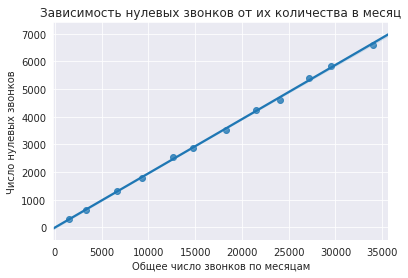

In [14]:
zcalls = calls.copy()
zcalls.loc[zcalls['duration'] == 0, 'zero_count'] = 1
zero_calls = zcalls.pivot_table(index='month', values=['id', 'zero_count'], aggfunc='count')
zero_calls['zero_ratio'] = round(zero_calls['zero_count'] / zero_calls['id'], 3)

sns.set_style("darkgrid")
sns.regplot(data=zero_calls, x='id', y='zero_count')
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число нулевых звонков')
_ = plt.title('Зависимость нулевых звонков от их количества в месяц')

In [15]:
zero_calls

,id,zero_count,zero_ratio
month,,,
1,1476,312,0.211
2,3328,623,0.187
3,6687,1304,0.195
4,9272,1768,0.191
5,12647,2531,0.200
6,14716,2883,0.196
7,18298,3518,0.192
8,21488,4231,0.197
9,24061,4615,0.192


In [16]:
calls['duration'] = calls['duration'].apply(np.ceil) # Округление до минуты звонков в диапазоне 0 - 1 мин.

Процент нулевых звонков в каждом месяце примерно одинаков, что видно из диаграммы и столбца с долями по месяцам. Из этого можно сделать вывод что звонки с нулевой длительностью - техническая особенность записи пропущенных либо сорвавшихся звонков. Данные значения оставлены без изменений.

#### Анализ нулевых сессий интернета

In [17]:
# Для сессий с трафиком 0
print('Доля нулевых сессий: {:.2%}'\
      .format(len(internet.query('mb_used == 0')) / len(internet)))

Доля нулевых сессий: 13.12%


In [18]:
internet['month'] = internet['session_date'].dt.month # Добавление столбца с номером месяца

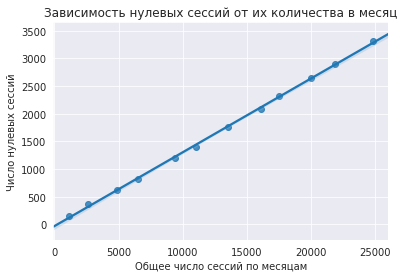

In [19]:
zinternet = internet.copy()
zinternet.loc[zinternet['mb_used'] == 0, 'izero_count'] = 1
zero_session = zinternet.pivot_table(index='month', values=['id', 'izero_count'], aggfunc='count')
zero_session['izero_ratio'] = round(zero_session['izero_count'] / zero_session['id'], 3)

sns.regplot(data=zero_session, x='id', y='izero_count')
plt.xlabel('Общее число сессий по месяцам')
plt.ylabel('Число нулевых сессий')
_ = plt.title('Зависимость нулевых сессий от их количества в месяц')

In [20]:
zero_session

,id,izero_count,izero_ratio
month,,,
1,1117,151,0.135
2,2641,378,0.143
3,4885,623,0.128
4,6511,819,0.126
5,9408,1199,0.127
6,11057,1401,0.127
7,13548,1760,0.130
8,16092,2083,0.129
9,17512,2314,0.132


Процент нулевых сессий интернета примерно одинаков каждый месяц, как и в случае с нулевыми звонками, можно отнести такие сессии к техническим моментом записи данных и оставить без изменения.

#### Удаление столбца Unnamed из датасета internet

In [21]:
del internet['Unnamed: 0']

Этот столбец не имеет функциональности, содержит копии индексов строк

### Группировка данных

#### Количество  звонков и израсходованных минут разговора по месяцам для каждого пользователя

In [22]:
# Группировка звонков по пользователю и месяцу
calls_grouped = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'id':'calls_count','duration':'calls_duration'})

In [23]:
calls_grouped

,user_id,month,calls_duration,calls_count
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47
3,1000,8,408.0,52
4,1000,9,466.0,58
...,...,...,...,...
3169,1498,10,247.0,41
3170,1499,9,70.0,9
3171,1499,10,449.0,68
3172,1499,11,612.0,74


#### Количество отправленных сообщений по месяцам для каждого пользователя

In [24]:
messages['month'] = messages['message_date'].dt.month # Добавление столбца с номером месяца
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [25]:
# Группировка сообщений по пользователю и месяцу
messages_grouped = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total'})

In [26]:
messages_grouped

,user_id,month,sms_total
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


#### Объем израсходованного интернет-трафика по месяцам для каждого пользователя

In [27]:
# Группировка мегабайт интернета  по пользователю и месяцу
internet_grouped = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total'})

In [28]:
internet_grouped

,user_id,month,mb_total
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


Произведена группировка звонков, сообщений и потребленного трафика по каждому пользователю в разрезе месяцев.

#### Формирование общего сгруппированного датасета

In [29]:
# Слияние группировки звонков сообщений и интернета
total_grouped = calls_grouped.merge(messages_grouped,on=['user_id', 'month'], how='outer')
total_grouped = total_grouped.merge(internet_grouped,on=['user_id', 'month'], how='outer')

In [30]:
total_grouped

,user_id,month,calls_duration,calls_count,sms_total,mb_total
0,1000,5,159.0,22.0,22.0,2253.49
1,1000,6,172.0,43.0,60.0,23233.77
2,1000,7,340.0,47.0,75.0,14003.64
3,1000,8,408.0,52.0,81.0,14055.93
4,1000,9,466.0,58.0,57.0,14568.91
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17206.30
3210,1489,10,NaN,NaN,21.0,19559.44
3211,1489,11,NaN,NaN,20.0,17491.56
3212,1489,12,NaN,NaN,35.0,17322.51


In [31]:
# Дополнительная проверка уникальности пользователей по строке город+имя+фамилия
users['unique'] = users['city'] + users['first_name'] + users['last_name']
users.describe(include=[object])

,city,first_name,last_name,tariff,unique
count,500,500,500,500,500
unique,76,246,419,2,500
top,Москва,Радим,Андреенко,smart,НижневартовскМальвинаВешнякова
freq,99,6,5,351,1


In [32]:
# Добавление информации о тарифах и городе
total_grouped = total_grouped.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='right')

In [33]:
total_grouped

,user_id,month,calls_duration,calls_count,sms_total,mb_total,tariff,city
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra,Краснодар
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra,Краснодар
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra,Краснодар
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra,Краснодар
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19559.44,smart,Санкт-Петербург
3212,1489,11.0,NaN,NaN,20.0,17491.56,smart,Санкт-Петербург
3213,1489,12.0,NaN,NaN,35.0,17322.51,smart,Санкт-Петербург
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra,Волжский


In [34]:
# Проверка на пропущенные значения при слияние
total_grouped.isna().sum()

user_id             0
month               2
calls_duration     42
calls_count        42
sms_total         499
mb_total           13
tariff              0
city                0
dtype: int64

In [35]:
total_grouped.query('month != month') # Пропуски по столубцу month

,user_id,month,calls_duration,calls_count,sms_total,mb_total,tariff,city
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra,Волжский
3215,1371,NaN,NaN,NaN,NaN,NaN,smart,Омск


Пропуски столбце month имеют пользователи с user_id 1128 и 1371, их не было ни в звонках ни в смс ни в интернете

In [36]:
users.query('user_id == 1128 or user_id == 1371') # Определение данных по пропущенным user_id

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,unique
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,ВолжскийКсенияАгаева
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,ОмскИринейТрофимов


Пользователи 1128 и 1371 купили тариф в декабре и тогда же его сменили без использования услуг. Пропуски в month будут заменены на декабрь

In [37]:
# Замена пропущеных значений при слиянии на 0
total_grouped['calls_duration'] = total_grouped['calls_duration'].fillna(0)
total_grouped['calls_count'] = total_grouped['calls_count'].fillna(0)
total_grouped['sms_total'] = total_grouped['sms_total'].fillna(0)
total_grouped['mb_total'] = total_grouped['mb_total'].fillna(0)
total_grouped['month'] = total_grouped['month'].fillna(12)

In [38]:
# Проверка на отсутствие пропусков после замены
total_grouped.isna().sum()

user_id           0
month             0
calls_duration    0
calls_count       0
sms_total         0
mb_total          0
tariff            0
city              0
dtype: int64

In [39]:
total_grouped

,user_id,month,calls_duration,calls_count,sms_total,mb_total,tariff,city
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra,Краснодар
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra,Краснодар
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra,Краснодар
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra,Краснодар
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19559.44,smart,Санкт-Петербург
3212,1489,11.0,0.0,0.0,20.0,17491.56,smart,Санкт-Петербург
3213,1489,12.0,0.0,0.0,35.0,17322.51,smart,Санкт-Петербург
3214,1128,12.0,0.0,0.0,0.0,0.00,ultra,Волжский


In [40]:
# Добавление в общую группировку тарифных значений из датасета tariffs
total_grouped.rename(columns={'tariff': 'tariff_name'}, inplace=True)
total_grouped = total_grouped.merge(tariffs, on='tariff_name', how='left')

In [41]:
total_grouped.head()

,user_id,month,calls_duration,calls_count,sms_total,mb_total,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra,Краснодар,1000,30720,3000,1950,150,1,1


In [42]:
# Подсчет сверх лимитных тратт по звонкам и добавление их в отделный столбец
def over_limit_mins_cost(row):
    mins = (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    total = 0
    for i in [mins]:
        if i > 0:
            total += i
    return total
total_grouped['over_limit_mins_cost'] = total_grouped.apply(lambda x: over_limit_mins_cost(x), axis=1)

In [43]:
# Подсчет сверх лимитных тратт по смс и добавление их в отделный столбец
def over_limit_sms_cost(row):
    sms = (row['sms_total'] - row['messages_included']) * row['rub_per_message']
    total = 0
    for i in [sms]:
        if i > 0:
            total += i
    return total
total_grouped['over_limit_sms_cost'] = total_grouped.apply(lambda x: over_limit_sms_cost(x), axis=1)

In [44]:
# Подсчет сверх лимитных тратт по трафику и добавление их в отделный столбец
def over_limit_mbs_cost(row):
    mbs = ((np.ceil((row['mb_total'] - row['mb_per_month_included']) / 1024)) * row['rub_per_gb'])
    total = 0
    for i in [mbs]:
        if i > 0:
            total += i
    return total
total_grouped['over_limit_mbs_cost'] = total_grouped.apply(lambda x: over_limit_mbs_cost(x), axis=1)

In [45]:
# Добавления столбцов с сверх лимитными траттами и общего дохода на пользователя
total_grouped['over_limit_cost'] = total_grouped['over_limit_mins_cost']\
                                + total_grouped['over_limit_sms_cost'] + total_grouped['over_limit_mbs_cost']
total_grouped['revenue_per_user'] = total_grouped['rub_monthly_fee'] + total_grouped['over_limit_cost']

In [46]:
total_grouped

,user_id,month,calls_duration,calls_count,sms_total,mb_total,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_limit_mins_cost,over_limit_sms_cost,over_limit_mbs_cost,over_limit_cost,revenue_per_user
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra,Краснодар,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19559.44,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.0,0.0,1000.0,1000.0,1550.0
3212,1489,11.0,0.0,0.0,20.0,17491.56,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.0,0.0,600.0,600.0,1150.0
3213,1489,12.0,0.0,0.0,35.0,17322.51,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.0,0.0,400.0,400.0,950.0
3214,1128,12.0,0.0,0.0,0.0,0.00,ultra,Волжский,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0


In [47]:
# Создание копии сгруппированного датасета, удаление колонок с деталями тарифа
grouped_metrics = total_grouped.copy()
grouped_metrics.drop(columns=[
    'messages_included',
    'mb_per_month_included',
    'minutes_included', 
    'rub_monthly_fee', 'rub_per_gb',
    'rub_per_message', 'rub_per_minute'],inplace=True)

In [48]:
grouped_metrics.sample(5)

,user_id,month,calls_duration,calls_count,sms_total,mb_total,tariff_name,city,over_limit_mins_cost,over_limit_sms_cost,over_limit_mbs_cost,over_limit_cost,revenue_per_user
1004,1160,10.0,336.0,47.0,41.0,17282.98,smart,Ульяновск,0.0,0.0,400.0,400.0,950.0
1736,1278,12.0,663.0,85.0,64.0,22592.40,smart,Новокузнецк,489.0,42.0,1600.0,2131.0,2681.0
1305,1207,8.0,246.0,39.0,11.0,15370.78,smart,Балашиха,0.0,0.0,200.0,200.0,750.0
1776,1284,8.0,474.0,74.0,44.0,14037.82,smart,Волгоград,0.0,0.0,0.0,0.0,550.0
2619,1412,12.0,757.0,106.0,55.0,32050.42,ultra,Волгоград,0.0,0.0,300.0,300.0,2250.0


<br>**При подготовке данных:**

<br>Заменены типы данных в столбцах с датами на тип datetime
<br>Проанализированы нулевые звонки, они имеют стабильную долю от всех звонков каждый месяц и растут вместе с количеством звонков, возможно это пропущенные или сорвавшиеся звонки попавшие в логи, данные оставлены как есть.
<br>Проанализированы нулевые сессии интернета, их доля также стабильна каждый месяц и растет вместе с действительным трафиком. Поскольку такие сессии также имеют техническую причину и попадают в логи, данные оставлены без изменения.
<br>Проведена группировка по количеству и длительности звонков, количеству сообщений и количеству потраченного трафика.
<br>Создан объединенный датасет с группировками, добавлены столбцы с городом пользователя, данными тарифа посчитан итоговый revenue per user, показатель дохода на каждого пользователя.

## Анализ данных

### Расчет среднемесячных значений по услугам

In [49]:
# Расчет средних значений, дисперсии, стандартного отклонения
stat_metrics = grouped_metrics.groupby('tariff_name')['calls_duration', 'mb_total', 'sms_total']\
  .agg({'calls_duration': [np.mean, np.median, np.var, np.std], 
        'mb_total': [np.mean, np.median, np.var, np.std], 
        'sms_total': [np.mean, np.median, np.var, np.std]}).applymap("{:.2f}".format)
stat_metrics.reset_index()

tariff_name calls_duration                             mb_total            \
                        mean  median        var     std      mean    median   
0       smart         417.75  421.50   36281.39  190.48  16201.12  16505.47   
1       ultra         526.09  518.00  101052.49  317.89  19449.06  19304.02   

                          sms_total                         
            var       std      mean median      var    std  
0   34564843.48   5879.19     33.37  28.00   796.96  28.23  
1  102032129.46  10101.10     49.31  38.00  2285.42  47.81

<br>В среднем абоненту Smart в месяц требуется 417 минут на звонки, около 16 гб трафика и 33 смс, очевидно что трафика входящего в абонентскую плату абонентам Smart не хватает.
<br>Медианное значения по звонкам и трафику в целом немного больше чем средняя, в смс - наоборот.

<br>В среднем абоненту Ultra в месяц требуется 527 минут на звонки около 19 гб трафика и 49 смс, в целом абоненты Ultra вписываются в тарифные ограничения входящие в абонентскую плату.
<br>Медианное значение по звонкам, трафику и  меньше чем среднее.

<br>Звонки, трафик и смс у абонентов Ultra имеют намного большую вариативность, что скорее объясняется широкими тарифными лимитами, которые абоненты Ultra не превышают. 
<br>Очевидно что трафика входящего в абонентскую плату абонентам Smart не хватает примерно на гигабайт.

Text(0, 0.5, 'количество смс')

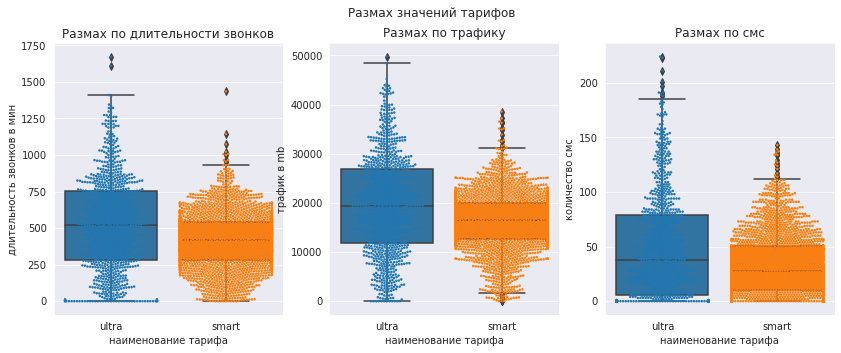

In [50]:
# Построение графиков размаха
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Размах значений тарифов')
sns.boxplot(ax=axes[0], data=grouped_metrics, x='tariff_name', y='calls_duration')
sns.swarmplot(ax=axes[0], data=grouped_metrics, x='tariff_name', y='calls_duration', size = 2.5)
axes[0].set_title('Размах по длительности звонков')
axes[0].set_xlabel('наименование тарифа')
axes[0].set_ylabel('длительность звонков в мин')
sns.boxplot(ax=axes[1], data=grouped_metrics, x='tariff_name', y='mb_total')
sns.swarmplot(ax=axes[1], data=grouped_metrics, x='tariff_name', y='mb_total', size = 2.5)
axes[1].set_title('Размах по трафику')
axes[1].set_xlabel('наименование тарифа')
axes[1].set_ylabel('трафик в mb')
sns.boxplot(ax=axes[2], data=grouped_metrics, x='tariff_name', y='sms_total')
sns.swarmplot(ax=axes[2], data=grouped_metrics, x='tariff_name', y='sms_total', size = 2.5)
axes[2].set_title('Размах по смс')
axes[2].set_xlabel('наименование тарифа')
axes[2].set_ylabel('количество смс')

<br>Диаграмы размаха подтверждаеют его больший размер у Ultra. 50% абонентов говорят от 320 до 760 минут, потребляют от 12 до 27 гб и посылают от нескольких до восьми десятков смс.
<br>Значения у Smart имеют более высокую плотность. 50% абонентов почти вписываются в тарифные лимты по звонкам и смс, но на примерно 4,5 гб превышают лимит трафика.
<br>У обоих тарифов есть высокие аномальные значения по звонкам и смс.

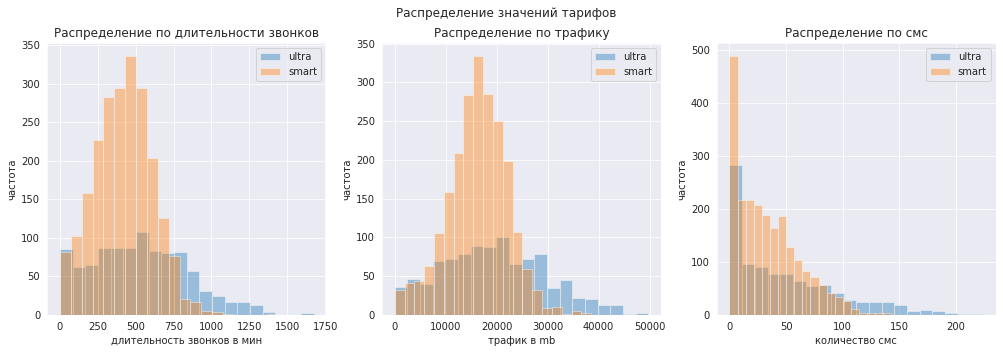

In [51]:
# Построение графиков распределения
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
fig.suptitle('Распределение значений тарифов')
sns.distplot(grouped_metrics.query("tariff_name == 'ultra'")['calls_duration'], ax=axes[0], kde=False, bins=20)
sns.distplot(grouped_metrics.query("tariff_name == 'smart'")['calls_duration'], ax=axes[0], kde=False, bins=20)
axes[0].set_title('Распределение по длительности звонков')
axes[0].set_xlabel('длительность звонков в мин')
axes[0].set_ylabel('частота')
axes[0].legend(['ultra', 'smart'])
sns.distplot(grouped_metrics.query("tariff_name == 'ultra'")['mb_total'], ax=axes[1], kde=False, bins=20)
sns.distplot(grouped_metrics.query("tariff_name == 'smart'")['mb_total'], ax=axes[1], kde=False, bins=20)
axes[1].set_title('Распределение по трафику')
axes[1].set_xlabel('трафик в mb')
axes[1].set_ylabel('частота')
axes[1].legend(['ultra', 'smart'])
sns.distplot(grouped_metrics.query("tariff_name == 'ultra'")['sms_total'], ax=axes[2], kde=False, bins=20)
sns.distplot(grouped_metrics.query("tariff_name == 'smart'")['sms_total'], ax=axes[2], kde=False, bins=20)
axes[2].set_title('Распределение по смс')
axes[2].set_xlabel('количество смс')
axes[2].set_ylabel('частота')
axes[2].legend(['ultra', 'smart'])

В целом распределения у обоих тарифов по звонкам и смс напоминают нормальное, в отличие от смс, которые одинаково не популярны.Возможные выбросы находятся справа.

<div class="alert alert-success">
<b>Комментарий ревьюера v1:</b>
    
Верные выводы и очень классная визуализация.
    
Для того, чтобы не показывать вспомогательные выводы python типа "matplotlib.axes._subplots.AxesSubplot at 0x7f5feaf7fc90', можно в конце строки добавить точку с запятой или plt.show()     
    
</div>

### Анализ сверхлимитных переплат по тарифным опциям

In [52]:
# Группировка перелимитов по месяцам
smart_m_overlim = grouped_metrics.query('tariff_name == "smart"').groupby('month', as_index=False)\
                                    ['over_limit_cost','revenue_per_user'].agg('mean')
ultra_m_overlim = grouped_metrics.query('tariff_name == "ultra"').groupby('month', as_index=False)\
                                    ['over_limit_cost','revenue_per_user'].agg('mean')
smart_m_overlim['month'] = smart_m_overlim['month'].astype(int)
ultra_m_overlim['month'] = ultra_m_overlim['month'].astype(int)

Text(0, 0.5, 'средняя переплата руб.')

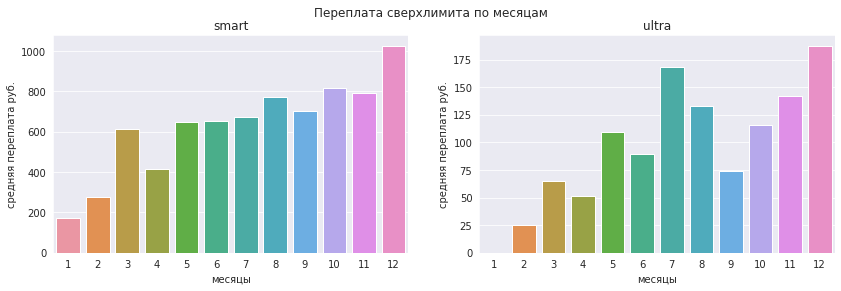

In [53]:
# График сверх лимитных переплат по месяцам
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Переплата сверхлимита по месяцам')
sns.barplot(data=smart_m_overlim, x='month', y='over_limit_cost', ax=axes[0])
axes[0].set_title('smart')
axes[0].set_xlabel('месяцы')
axes[0].set_ylabel('средняя переплата руб.')
sns.barplot(data=ultra_m_overlim, x='month', y='over_limit_cost', ax=axes[1])
axes[1].set_title('ultra')
axes[1].set_xlabel('месяцы')
axes[1].set_ylabel('средняя переплата руб.')

По обоим тарифам стоимость сверхлимитных переплат растет в течении года. Пик приходится на декабрь, локальные пики у Smart - март, у Ultra - летние месяцы и околоноулевые переплаты в январе. По данным одного года трудно сделать однозначный вывод о сезонности в стоимости переплат, весьма вероятны случайные пики. Нельзя не учитывать и общие тренды, такие как например глобальный рост потребления мобильного интернета в связи с развитием мобильных приложений.

In [54]:
# Расчет доли пользователей smart переплачивающих за услуги
print('Пользователей smart переплативших за сверхлимит {:.2%}'.format\
(grouped_metrics.query('tariff_name == "smart" and over_limit_cost > 0').groupby('user_id')\
['over_limit_cost'].agg('count').count()\
/ len(grouped_metrics.query('tariff_name == "smart"').groupby('user_id').count())))

Пользователей smart переплативших за сверхлимит 94.87%


In [55]:
# Расчет доли пользователей ultra переплачивающих за услуги
print('Пользователей ultra переплативших за сверхлимит {:.2%}'.format\
(grouped_metrics.query('tariff_name == "ultra" and over_limit_cost > 0').groupby('user_id')\
['over_limit_cost'].agg('count').count()\
/ len(grouped_metrics.query('tariff_name == "ultra"').groupby('user_id').count())))

Пользователей ultra переплативших за сверхлимит 28.86%


Почти каждый абонент тарифа Smart переплачивал хоть раз в  год за сверхлимитные услуги, среди абонентов Ultra таких - чуть меньше трети.

In [56]:
# Расчет средних значений переплат в рублях по видам услуг
over_limit_metrics = grouped_metrics.groupby('tariff_name')\
['over_limit_mins_cost', 'over_limit_mbs_cost', 'over_limit_sms_cost']\
  .agg({'over_limit_mins_cost': [np.mean, np.median, np.var, np.std], 
        'over_limit_mbs_cost': [np.mean, np.median, np.var, np.std], 
        'over_limit_sms_cost': [np.mean, np.median, np.var, np.std]}).applymap("{:.2f}".format)
over_limit_metrics.reset_index()

tariff_name over_limit_mins_cost                           \
                              mean median       var     std   
0       smart               124.76   0.00  64512.18  253.99   
1       ultra                 0.00   0.00      0.00    0.00   

  over_limit_mbs_cost                            over_limit_sms_cost         \
                 mean  median        var     std                mean median   
0              597.49  400.00  542443.22  736.51               17.39   0.00   
1              120.03    0.00  141387.71  376.02                0.00   0.00   

                   
       var    std  
0  1625.70  40.32  
1     0.00   0.00

In [57]:
over_limit_metrics.iloc[0]['over_limit_mins_cost'] = over_limit_metrics.iloc[0]['over_limit_mins_cost'].astype(float)
over_limit_metrics.iloc[0]['over_limit_mbs_cost'] = over_limit_metrics.iloc[0]['over_limit_mins_cost'].astype(float)
over_limit_metrics.iloc[0]['over_limit_sms_cost'] = over_limit_metrics.iloc[0]['over_limit_mins_cost'].astype(float)

In [58]:
# Расчет среднего перерасхода в минутах
print('Среднемесячный перерасход в минутах пользователей smart {:.2F}'.format(over_limit_metrics.iloc[0]['over_limit_mins_cost']['mean']\
/ tariffs.loc[0, 'rub_per_minute']))

Среднемесячный перерасход в минутах пользователей smart 41.59


In [59]:
# Расчет столбца с перерасходом трафика в mb
def over_limit_mbs(row):
    mbs = row['mb_total'] - row['mb_per_month_included']
    total = 0
    for i in [mbs]:
        if i > 0:
            total += i
    return total
total_grouped['over_limit_mbs'] = total_grouped.apply(lambda x: over_limit_mbs(x), axis=1)

In [60]:
# Расчет среднего перерасхода трафика
average_overlimit_mbs_smart = total_grouped.query('tariff_name == "smart"').groupby('user_id')['over_limit_mbs'].agg('mean')
print('Среднемесячный перерасход в mb пользователей smart {:.2F}'.format(average_overlimit_mbs_smart.mean()))
print('Среднемесячный перерасход в gb пользователей smart {:.2F}'.format(average_overlimit_mbs_smart.mean() / 1024))

Среднемесячный перерасход в mb пользователей smart 2854.67
Среднемесячный перерасход в gb пользователей smart 2.79


In [61]:

average_overlimit_mbs_ultra = total_grouped.query('tariff_name == "ultra"').groupby('user_id')['over_limit_mbs'].agg('mean')
print('Среднемесячный перерасход в mb пользователей ultra {:.2F}'.format(average_overlimit_mbs_ultra.mean()))
print('Среднемесячный перерасход в gb пользователей ultra {:.2F}'.format(average_overlimit_mbs_ultra.mean() / 1024))

Среднемесячный перерасход в mb пользователей ultra 851.34
Среднемесячный перерасход в gb пользователей ultra 0.83


<br>В числе тех кто платил за сверхлимит тарифных опций - в основном абоненты Smart, им каждый месяц в среднем не хаватло 42 минут разговоров и почти 3 гб интернета, который по условиям тарифа вверх округляется до гб.
<br>Абонентам Ultra переплачивающим за сверхлимит не хватает в среднем около гб интернета.
<br>Можно заключить что мобильный интернет - главный драйвер сверхлимитных переплат и соответственно выручки.

<div class="alert alert-success">
<b>Комментарий ревьюера v1:</b>
    
Да сообщения и звонки уже мало кому нужны.   
</div>

### Анализ средней выручки на абонента

In [62]:
# Расчет средних метрик по выручке на абонента
av_metrics = grouped_metrics.groupby('tariff_name')['revenue_per_user'].agg(['mean','median','var', 'std'])
av_metrics.reset_index()

,tariff_name,mean,median,var,std
0,smart,1289.641704,1021.0,669730.763895,818.370799
1,ultra,2070.030426,1950.0,141387.714809,376.015578


Ненормализованная (с учетом всех значений распределения) средняя выручка на абонета Ultra на 60% больше чем на абонента Smart, медианная - почти в два раза выше. Медиана выручки на абонента Ultra совпадает с размером месячной абонентской платы, у абонентов Smart - чуть менее 2 месячных абонентских плат.

Text(0, 0.5, 'выручка на абонента руб.')

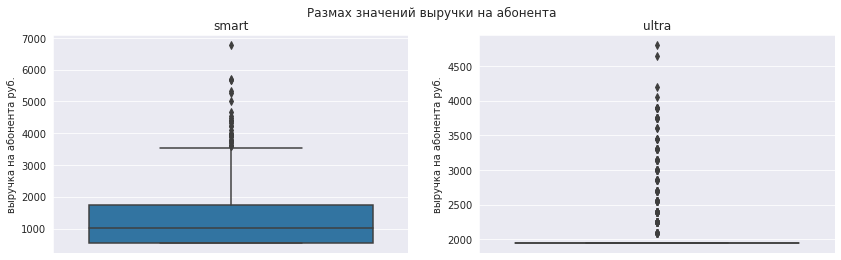

In [63]:
# Построение диаграммы размаха значений выручки на абонента в разрезе тарифов
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Размах значений выручки на абонента')
sns.boxplot(data=grouped_metrics.query('tariff_name == "smart"'), y='revenue_per_user', ax=axes[0])
axes[0].set_title('smart')
axes[0].set_ylabel('выручка на абонента руб.')
sns.boxplot(data=grouped_metrics.query('tariff_name == "ultra"'), y='revenue_per_user', ax=axes[1])
axes[1].set_title('ultra')
axes[1].set_ylabel('выручка на абонента руб.')

<br>Абоненты Smart часто платят за сверхлимит сравнительно много, экстремальные значения находятся выше границы около 3600 руб. 75% абонентов Smart приносят выручку от 550 до чуть менее чем 2000 руб.
<br>Подавляющее большинство абонентов Ultra платят только абонентскую плату, но экстремальные значения также присутствуют.

Text(0.5, 0, 'выручка на абонента руб.')

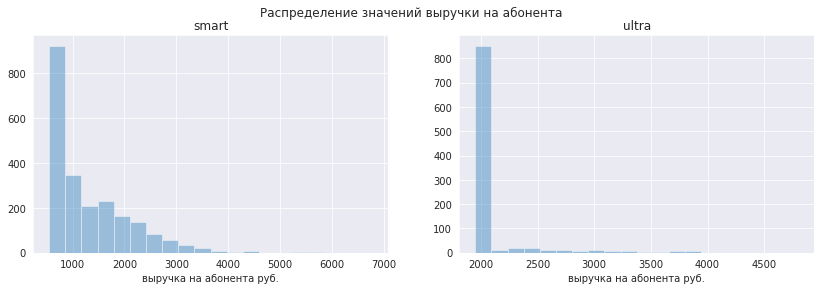

In [64]:
# Построение дииаграммы распределения значений выручки на абонента в разрезе тарифов
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Распределение значений выручки на абонента')
sns.distplot(grouped_metrics.query('tariff_name == "smart"')['revenue_per_user'], ax=axes[0], kde=False, bins=20)
axes[0].set_title('smart')
axes[0].set_xlabel('выручка на абонента руб.')
sns.distplot(grouped_metrics.query('tariff_name == "ultra"')['revenue_per_user'], ax=axes[1], kde=False, bins=20)
axes[1].set_title('ultra')
axes[1].set_xlabel('выручка на абонента руб.')

Диаграмма распеределения значений по выручке подтверждает вывод о том что абоненты Smart часто не укладываются в абонентскую плату.

### Обработка выбросов по выручке с абонента

In [65]:
# Расчет 99 процентиля для отсечения выбросов для smart
outliers_lim_smart = grouped_metrics.query('tariff_name == "smart"')['revenue_per_user'].quantile(.99)
print('{:.0f}'.format(outliers_lim_smart))

3774


In [66]:
# Расчет 99 процентиля для отсечения выбросов для ultra
outliers_lim_ultra = grouped_metrics.query('tariff_name == "ultra"')['revenue_per_user'].quantile(.99)
print('{:.0f}'.format(outliers_lim_ultra))


3772


Поскольку экстремальные значения сильно искажают среднее, необходимо нормализовать значения по выручке. В качестве границ отсечения экстремальных значений,расчитаны 99 персентили распределения поскольку распределения сложно назвать нормальными.

In [67]:
# Удаление выбросов из датафреймов тарифов
grouped_metrics.drop\
(grouped_metrics[
((grouped_metrics['tariff_name'] == "smart") & (grouped_metrics['revenue_per_user'] > outliers_lim_smart))\
| ((grouped_metrics['tariff_name'] == "ultra") & (grouped_metrics['revenue_per_user'] > outliers_lim_ultra))
].index, inplace=True)

<br>В целом средние значения по видам услуг близки к медианам, за исключением смс - тут дельта больше. Вариативность значений значительно больше у абонентов Ultra.
<br>В среднем абоненты Smart укладываются в лимиты звонков и смс но выходят за рамки лимита по трафику. Подовляющее большинство абонентов хотя бы раз за год платили за перелимит. В среднем им не хватает пятой части объема лимитного трафика. Больше всего переплат в декабре, меньше всего - в январе.
<br>Абоненты Ultra активно пользуются широтой тарифных лимитов, хоть раз переплачивали только треть, за интернет траффик.
<br>В среднем выручка абонентов Smart превышает месячную абонентску плату в 2 раза, абонентов Ultra - на размер одной месячной абонентской платы.

## Анализ гипотез

### Гипотеза относительно средней выручки «Ультра» и «Смарт»

<br>**Первая гипотеза представленная для проверки - средняя выручка от абонентов тарифа "Смарт" равна средней выручке от абонентов с тарифа "Ультра".**

<br>Следовательно гипотезы можно сформулировать:

<br>**$Ho$**  - средняя выручка от абонентов тарифа "Ультра" равна средней выручке от абонентов тарифа "Смарт"
<br>**$H1$**  - средние выручки отличаются

In [68]:
smart = grouped_metrics.query('tariff_name == "smart"')['revenue_per_user']
ultra = grouped_metrics.query('tariff_name == "ultra"')['revenue_per_user']

Общая выручки по тарифам

In [69]:
print('Дисперсия выборки абонентов тарифа Смарт:', smart.var(ddof=1))
print('Дисперсия выборки абонентов тарифа Ультра:', ultra.var(ddof=1))

Дисперсия выборки абонентов тарифа Смарт: 552579.97867126
Дисперсия выборки абонентов тарифа Ультра: 98647.95870113492


Расчитаны дисперсии для тарифов со степенью свободы 1, поскольку это значение обеспечивает непредвзятую оценку выборочной дисперсии.

In [70]:

alpha=0.01
results = st.ttest_ind(smart, ultra, equal_var=False) 
print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print("Необходимо отвергнуть нулевую гипотезу")
else:
    print("Не нужно отвергать нулевую гипотезу")

p-value: 2.088237718377e-311
Необходимо отвергнуть нулевую гипотезу


In [71]:
# Расчет средних значений очищенного от выбросов датафрейма
av_metrics_total = grouped_metrics.groupby('tariff_name')\
['revenue_per_user'].agg(['mean','median']).applymap("{:.2f}".format)
av_metrics_total.reset_index()

,tariff_name,mean,median
0,smart,1254.72,1009.00
1,ultra,2049.13,1950.00


<br>Для проверки гипотезы применен t критерий Стьюдента для двух независимых выборок, выборки > 500, предположение о нормальности генеральных совокупностей, учтен фактор разности дисперсий, отсечены экстремальные значения.
<br>В результате теста есть основания отвергнуть нулевую гипотезу о том что средние выручки на тарифах Smart и Ultra равны
<br>Значения средней выручки на абонента (в отрасли принято обозначать ARPU) в представленных выборках различаются на более чем на 60%

### Гипотеза относительно средней выручки Москвы и других регионов

<br>**Вторая гипотеза представленная для проверки - средняя выручка от абонентов из Москвы равна средней выручке от абонентов из других регионов.**

<br>Следовательно гипотезы можно сформулировать:

<br>**$Ho$**  - средняя выручка от абонентов из Москвы равна средней выручке от абонентов из других регионов.
<br>**$H1$**  - средние выручки отличаются

In [72]:
moscow = grouped_metrics.query('city == "Москва"')['revenue_per_user']
other_regions = grouped_metrics.query('city != "Москва"')['revenue_per_user']

Группировка выручки по Москве и регионам

In [73]:
print('Дисперсия выборки абонентов Москвы:', moscow.var(ddof=1))
print('Дисперсия выборки абонентов остальных городов:', other_regions.var(ddof=1))

Дисперсия выборки абонентов Москвы: 515149.69199819496
Дисперсия выборки абонентов остальных городов: 555104.6073780379


Расчитаны дисперсии для тарифов со степенью свободы 1, поскольку это значение обеспечивает непредвзятую оценку выборочной дисперсии.

In [74]:
alpha=0.05
results = st.ttest_ind(moscow, other_regions, equal_var=False) 
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Необходимо отвергнуть нулевую гипотезу")
else:
    print("Не нужно отвергать нулевую гипотезу")

p-значение: 0.2568501478964274
Не нужно отвергать нулевую гипотезу


In [75]:
# Добавление столбца с регионами для группировки
def get_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
grouped_metrics['region'] = grouped_metrics['city'].apply(get_region)

In [76]:
# Группировка средних выручек и медиан по регионам
av_metrics_regional = grouped_metrics.groupby('region')\
['revenue_per_user'].agg(['mean','median']).applymap("{:.2f}".format)
av_metrics_regional.reset_index()

,region,mean,median
0,Другой регион,1491.25,1553.00
1,Москва,1528.26,1750.00


<br>Для проверки гипотезы применен t критерий Стьюдента для двух независимых выборок, выборки > 500, предположение о нормальности генеральных совокупностей, учтен фактор разности дисперсий, отсечены экстремальные значения.
<br> Несмотря на то что, в представленных выборках средние выручки на абонента в Москве выше на 2% чем в регионах, в результате теста оснований отвергнуть нулевую гипотезу не обнаружено.

## Общий вывод

<br>Анализ проведен по выборке в 500 абонентов, 351 абонент тарифа Smart и 149 абонентов тарифа Ultra

<br>**При проведении анализа выявлено:**

<br>1. Абоненты Smart в средем переплачивают за сверхлимт тарифных опций 124 руб за звонки, 597 руб за мобильный интернет, 17 руб за сообщения. В среднем абонентам Smart не хватает 41 минуты разговора и 2.79 гигабайт трафика, причем при тарификации минуты и мегабайты округляются в большую сторону. Рост переплат - с января по декабрь.
<br>2. Абоненты Ultra широко используют возможности больших лимитов и в среднем переплачивают только 120 руб за сверхлимит мобильного интернета в размере менее гигабайта. Переплаты также ростут с февраля по декабрь, с локальным пиком летом.
<br>3. Средняя выручка на абонента тарифа Ultra превышают среднюю выручку абонента Smart более чем на 60%, медианные - почти в два раза. С вероятностью 99% различие в средних выручках тарифов Smart и Ultra подтверждено статистическими методами для всей совокупности абонентов тарифов на основании предстваленной выборки.
<br>4. Средние выручки на абонента для Москвы и других регионов не различаются для всей совокупности абонентов, статистически значимые различия не подтверждены. В представленной выборке среднии выручки различаются незначительно, что обусловлено совойствами выборки.

**Вывод: тариф Ultra является в среднем более доходным по выручке на абонента, вне зависимости от региона.**

*Рекомендации:*

<br>Для тарифа Smart возможно расширить тарифные лимиты, в части трафика и возможно в части звонков, с пропорциональным увеличением абонентской платы, либо дополнительными специальными опциями. Части абонентов Smart регулярно переплачивающих за сверхлимитные опции возможно предложить переход на тариф с расширенными лимитами. 
<br>Для тарифа Ultra можно перекомбинирование тарифных лимитов - увеличение лимита трафика, с уменьшением лимитов по звонкам и сообщениям, поскольку полностю они не используются.
<br>Рекламные акценты и промо должны учитывать общий тренд на увеличение потребления мобильного трафика вариативностью лимитов и опций.